<a href="https://colab.research.google.com/github/MaxKochanov/Skull-segmentation/blob/main/skull_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
data_root = '/content/drive/My Drive/dicom/'

In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from albumentations import *
import os

In [5]:
images = []
for fold in tqdm(os.listdir(data_root)):
  count = 0
  for item in os.listdir(data_root + fold + '/9_reg_t1c/'):
    if count == 50:
      count +=1 
      continue
    else:
      images.append(data_root + fold + '/9_reg_t1c/' + item)
      count += 1

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


In [6]:
masks = []
for fold in tqdm(os.listdir(data_root)):
  count = 0
  for item in os.listdir(data_root + fold + '/Label/Label/'):
    if count == 50:
      count += 1
      continue
    else:
      masks.append(data_root + fold + '/Label/Label/' + item)
      count += 1

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


In [7]:
images = np.array(images)
masks = np.array(masks)

dataset = np.c_[images, masks]
dataset.shape

(900, 2)

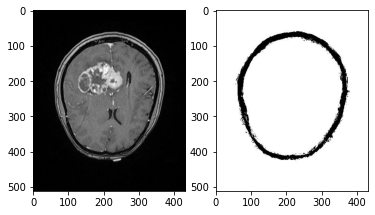

In [8]:
number = 405

f = plt.figure()
f.add_subplot(1,2, 1)
img = cv2.imread(dataset[number][0])
plt.imshow(img)
f.add_subplot(1,2, 2)
mask = cv2.imread(dataset[number][1])
plt.imshow(mask)
plt.show(block=True)

In [9]:
mask.shape

(512, 432, 3)

In [10]:
test = []
for fold in tqdm(os.listdir(data_root)):
  count = 0
  for item in os.listdir(data_root + fold + '/9_reg_t1c/'):
    if count == 50:
      count +=1 
      test.append(data_root + fold + '/9_reg_t1c/' + item)
    else:
      count += 1
      continue

100%|██████████| 10/10 [00:00<00:00, 621.67it/s]


In [11]:
test_masks = []
for fold in tqdm(os.listdir(data_root)):
  count = 0
  for item in os.listdir(data_root + fold + '/Label/Label/'):
    if count == 50:
      count +=1 
      test_masks.append(data_root + fold + '/Label/Label/' + item)
    else:
      count += 1
      continue

100%|██████████| 10/10 [00:00<00:00, 592.93it/s]


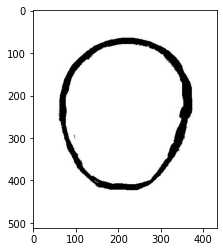

In [73]:
plt.figure()
img = cv2.imread(test_masks[5])
plt.imshow(img)
plt.show(block=True)

In [13]:
img.shape

(512, 432, 3)

# Import

In [14]:
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Input, Dropout
from keras.layers import Dropout
from keras import optimizers
from keras.layers import Flatten, Activation, concatenate, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from keras import backend as K

# Generator

In [15]:
class DataGeneratorFull(Sequence):
    'Generates data for Keras'

    def __init__(self,
                 files,
                 target_df=None,
                 target_size=512,
                 mode='fit',
                 batch_size=8,
                 fill_mode='nearest',
                 rescale=1 / 255.,
                 shuffle=True,
                 augmentation=None):
        self.batch_size = batch_size
        self.files = files
        self.target_size = target_size
        self.mode = mode
        self.shuffle = shuffle
        self.rescale = rescale
        self.aug = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.files[index * self.batch_size:(index + 1) *
                                 self.batch_size]

        if self.mode == 'fit':

            X = np.empty((self.batch_size, self.target_size, self.target_size, 3))
            y = np.empty((self.batch_size, self.target_size, self.target_size, 2))

            images_temp = [elem[0] for elem in batch_files]
            masks_temp = [elem[1] for elem in batch_files]

            for i in range(len(batch_files)):
                image = cv2.imread(images_temp[i])
                mask = cv2.imread(masks_temp[i])
                if self.aug:
                    augmented = self.aug(image=image, mask=mask)
                    image = augmented['image']
                image = cv2.resize(image, (self.target_size, self.target_size))
                image = image * self.rescale
                image = np.array(image)
                X[i, ] = image

                if self.aug:
                    mask = augmented['mask']
                mask = cv2.resize(mask, (self.target_size, self.target_size))
                mask = mask * self.rescale   
                mask = np.array(mask)   
                y[i, :, :, 0] = mask[:, :, 0]
                y[i, :, :, 1] = mask[:, :, 1]
            return X, y

        elif self.mode == 'predict':
            X = []  # np.empty((self.batch_size, 512,512,3))
            for i in batch_files:
                image = cv2.imread(i)
                image = cv2.resize(image, (self.target_size, self.target_size))
                image = image * self.rescale
                X.append(image)
            return np.array(X)
        else:
            raise AttributeError(
                'The parameter mode should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [16]:
train_files, val_files = train_test_split(dataset,
                                          test_size=0.1,
                                          random_state=2020)

In [17]:
test_gen = DataGeneratorFull(test,
                             batch_size=len(test),
                             mode='predict')

# U-net

In [18]:
def Unet(pretrained_weights=None, descr=1, input_size=(512, 512, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(int(1024 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(int(1024 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(int(512 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(int(512 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(int(256 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(int(256 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(int(128 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(int(128 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(int(64 / descr),
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2,
                                                                    2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(int(64 / descr),
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(4,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(2, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [19]:
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +
                                           smooth)


def dice_loss(y_true, y_pred):
    # smooth = 1.
    # y_true_f = K.flatten(y_true)
    # y_pred_f = K.flatten(y_pred)
    # intersection = y_true_f * y_pred_f
    # score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) +
    #                                                K.sum(y_pred_f) + smooth)
    return 1. - dice_coef(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#Trainig U-net

In [20]:
augmentation = Compose([
    VerticalFlip(p=0.5),
    HorizontalFlip(p=0.5),
    RandomRotate90(p=0.5),
], p=0.75)

In [21]:
TARGET_SIZE = 512

In [22]:
gen_unet = DataGeneratorFull(train_files,
                        batch_size=8, target_size = TARGET_SIZE, augmentation= augmentation)
val_unet = DataGeneratorFull(val_files,
                        batch_size=8, target_size = TARGET_SIZE, augmentation= augmentation)

In [23]:
unet = Unet(pretrained_weights='/content/drive/MyDrive/Skull_segmentation_unet/weights150epochs.h5', input_size=(TARGET_SIZE,TARGET_SIZE,3), descr=8)

In [24]:
unet.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=bce_dice_loss,
              metrics=['acc', dice_coef])

In [25]:
# history_unet = unet.fit(gen_unet,
#                         validation_data=val_unet,
#                         verbose=2,
#                         epochs=150)

#Save weights

In [26]:
# unet.save_weights('/content/drive/My Drive/Skull_segmentation_unet/weights150epochs.h5')
# print('Saved')

# *Test* U-net

In [27]:
test_result_unet = unet.predict(test_gen)

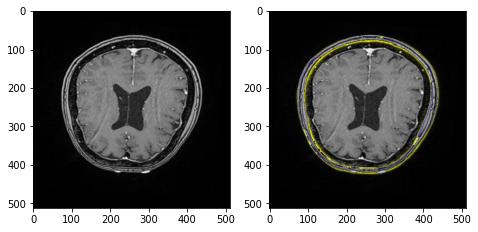

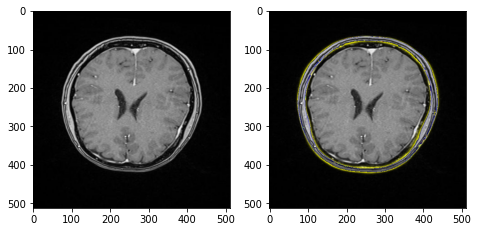

In [28]:
imgs = test_gen.__getitem__(0)
for i in range(2):
  f = plt.figure(figsize=(12,12))
  f.add_subplot(1,3,1)
  plt.imshow((imgs[i] * 255).astype('uint8'))
  mask = test_result_unet[i]
  imgs[i][:,:,0] += (1-mask[:,:,0])
  imgs[i][:,:,1] += (1-mask[:,:,1])
  f.add_subplot(1,3,2)
  plt.imshow((imgs[i]*255).astype('uint8'))
  plt.show(block=True)

1. как сделать норм наложение маски


# DoubleU-Net

In [29]:
!git clone https://github.com/DebeshJha/2020-CBMS-DoubleU-Net
!mv 2020-CBMS-DoubleU-Net doubleunet

Cloning into '2020-CBMS-DoubleU-Net'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 93 (delta 42), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (93/93), done.


In [30]:
from doubleunet.model import build_model

In [31]:
double_unet = build_model((512, 512, 3))

80142336/80134624 [==============================] - 0s 0us/step


In [32]:
%cd /content/doubleunet
from utils import load_model_weight

/content/doubleunet


In [33]:
double_unet = load_model_weight('/content/drive/MyDrive/DoubleU-Net_weights/CVC-612model.h5')

In [34]:
double_unet.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=bce_dice_loss,
              metrics=['acc', dice_coef])

In [35]:
gen_double_unet = DataGeneratorFull(train_files,
                        batch_size=4, target_size = TARGET_SIZE, augmentation= augmentation)
val_double_unet = DataGeneratorFull(val_files,
                        batch_size=4, target_size = TARGET_SIZE, augmentation= augmentation)

In [36]:
# double_unet.fit(gen_double_unet,
#                 validation_data=val_double_unet,
#                 verbose=2,
#                 epochs=10)

## Test DoubleU-Net

In [37]:
test_result_double_unet = double_unet.predict(test_gen)

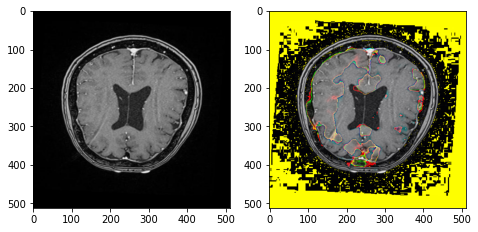

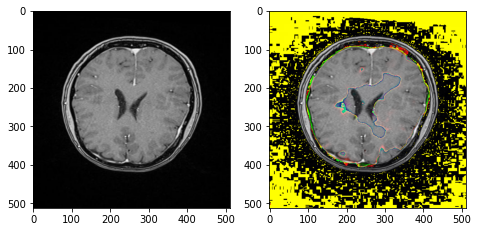

In [38]:
imgs = test_gen.__getitem__(0)
for i in range(2):
  f = plt.figure(figsize=(12,12))
  f.add_subplot(1,3,1)
  plt.imshow((imgs[i] * 255).astype('uint8'))
  mask = test_result_double_unet[i]
  imgs[i][:,:,0] += (1-mask[:,:,0])
  imgs[i][:,:,1] += (1-mask[:,:,1])
  f.add_subplot(1,3,2)
  plt.imshow((imgs[i]*255).astype('uint8'))
  plt.show(block=True)

# Pix2Pix

In [39]:
import os
os.chdir('/content/')
!rm -rf pix2pix

Интсрукция запуска в Colab https://colab.research.google.com/github/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/pix2pix.ipynb#scrollTo=OzSKIPUByfiN

In [40]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
!mv pytorch-CycleGAN-and-pix2pix pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2337, done.
remote: Total 2337 (delta 0), reused 0 (delta 0), pack-reused 2337
Receiving objects: 100% (2337/2337), 8.09 MiB | 37.16 MiB/s, done.
Resolving deltas: 100% (1498/1498), done.


In [41]:
os.chdir('/content/pix2pix')
!pip install -r requirements.txt

     |████████████████████████████████| 686kB 18.3MB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655252 sha256=915560fd3e1e8f785c439fb7c92b4c3661fbd9754df9fe81c8b962a12244c1c7
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5713 sha256=e256fb4d5bd33cdb93d669a83fe4754c03df18fd5eba725c861e14e01779b06b
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


Подготовим данные для Pix2Pix по инструкции на https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

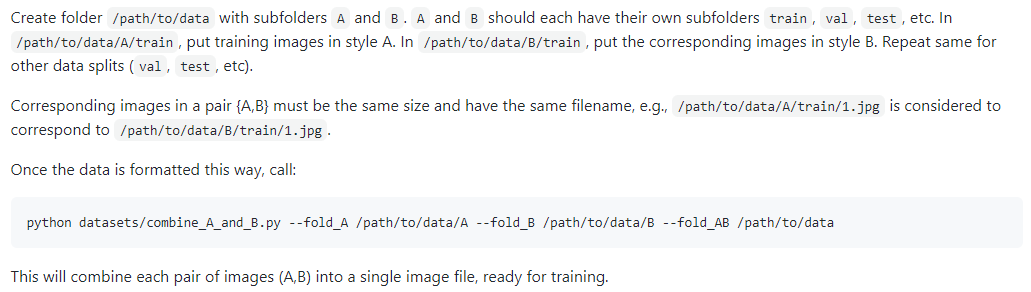

In [42]:
import shutil
for i in tqdm(range(train_files.shape[0])): 
  shutil.copyfile(train_files[i][0], '/content/drive/MyDrive/Pix2Pix/A/train/sample_' + str(i) + '.jpg')
  shutil.copyfile(train_files[i][1], '/content/drive/MyDrive/Pix2Pix/B/train/sample_' + str(i) + '.jpg')

100%|██████████| 810/810 [06:10<00:00,  2.18it/s]


In [43]:
for i in tqdm(range(val_files.shape[0])):
  shutil.copyfile(val_files[i][0], '/content/drive/MyDrive/Pix2Pix/A/val/sample_' + str(i) + '.jpg')
  shutil.copyfile(val_files[i][1], '/content/drive/MyDrive/Pix2Pix/B/val/sample_' + str(i) + '.jpg')

100%|██████████| 90/90 [00:39<00:00,  2.28it/s]


In [44]:
for i in tqdm(range(len(test))):
  shutil.copyfile(test[i], '/content/drive/MyDrive/Pix2Pix/A/test/sample_' + str(i) + '.jpg')
  shutil.copyfile(test_masks[i], '/content/drive/MyDrive/Pix2Pix/B/test/sample_' + str(i) + '.jpg')

100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


In [45]:
!python datasets/combine_A_and_B.py --fold_A /content/drive/MyDrive/Pix2Pix/A --fold_B /content/drive/MyDrive/Pix2Pix/B --fold_AB /content/drive/MyDrive/Pix2Pix/AB

[fold_A] =  /content/drive/MyDrive/Pix2Pix/A
[fold_B] =  /content/drive/MyDrive/Pix2Pix/B
[fold_AB] =  /content/drive/MyDrive/Pix2Pix/AB
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = test, use 10/10 images
split = test, number of images = 10
split = val, use 90/90 images
split = val, number of images = 90
split = train, use 810/810 images
split = train, number of images = 810


In [48]:
!python train.py --dataroot /content/drive/MyDrive/Pix2Pix/AB --name skulls_pix2pix --model pix2pix

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/Pix2Pix/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
           

In [49]:
!ls checkpoints/

skulls_pix2pix


In [50]:
!python test.py --dataroot /content/drive/MyDrive/Pix2Pix/AB --model pix2pix --name skulls_pix2pix

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/Pix2Pix/AB	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                         

In [ ]:
path + 'sample_' + str(0) + '_fake_B'

'/content/pix2pix/results/skulls_pix2pix/test_latest/images/sample_0_fake_B'

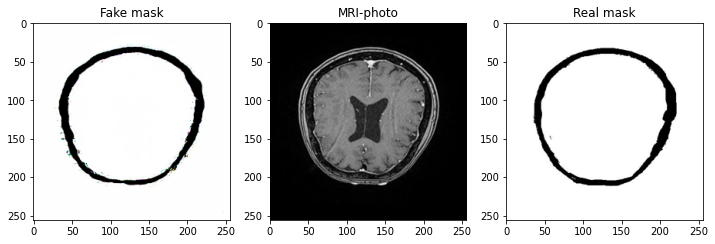

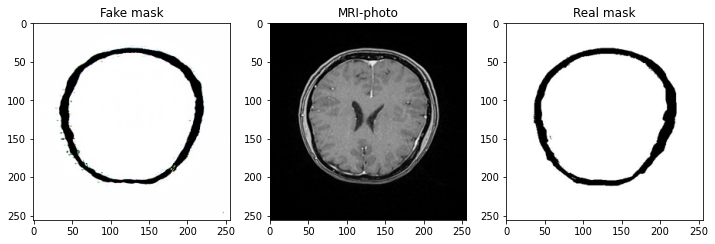

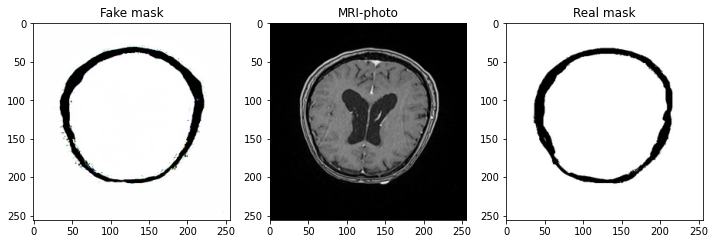

In [76]:
path = '/content/pix2pix/results/skulls_pix2pix/test_latest/images/'
for i in range(3):
  f, axes = plt.subplots(1, 3)
  f.set_size_inches(12,12)
  fake_mask = cv2.imread(path + 'sample_' + str(i) + '_fake_B.png')
  axes[0].imshow(fake_mask)
  axes[0].set_title('Fake mask')
  pic = cv2.imread(path + 'sample_' + str(i) + '_real_A.png')
  axes[1].imshow(pic)
  axes[1].set_title('MRI-photo')
  real_mask = cv2.imread(path + 'sample_' + str(i) + '_real_B.png')
  axes[2].imshow(real_mask)
  axes[2].set_title('Real mask')